<a href="https://colab.research.google.com/github/otvet4ikov/castle/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1><center>Вступление</center></h1>
</div>
Описание датасета.

Данный датасет содержит картинки рукописных цифр от 0 до 9. Размер картинки 28x28 пикселей. 

Тренировочный датасет содержит 60000 картинок, тестовый датасет содержит 20000 картинок. 

Будет сравниваться две нейронные сети. Первая - полносвязная нейронная сеть со 100 скрытыми нейронами, два линейных слоев и сигмоидной функцией активации. Вторая модифицированная сеть [LeNet](https://habr.com/ru/company/nix/blog/430524/). Так как сеть LeNet работала с размером картинок 32x32, а у нас 28x28, то я использовал на первом сверточном слое маску размером 5x5 с отступом 2.

В обучении размер батча будет равен 100, для оптимизации будет использована кросс-энтропия и оптимизатор Адам



Импортируем библиотеки и создадим воспроизводимость экспериментов

In [ ]:
# библиотека для создания нейронных сетей и преедобработки данных
import torch
import torchvision.transforms as tfs
from torch.utils.data import DataLoader


# библиотеки для математических операций и оценки точности
import random
import numpy as np
from sklearn.metrics import accuracy_score


# библиотека для визуализации
import matplotlib.pyplot as plt


# воспроизводимость экспериментов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


import time

Создадим трансформер для преобразования картинки к тензору и нормализуем данные

In [ ]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

Скачаем датасеты для обучения и проверки

In [ ]:
from torchvision.datasets import MNIST

train = MNIST('./', train=True,  transform=data_tfs, download=True)
test  = MNIST('./', train=False, transform=data_tfs, download=True)

Создадим полносвязную нейронную сеть

In [ ]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.ac1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    return x


mnist_net = MNISTNet(100)

Для оптимизации будем использовать кросс-энтропию и оптимизатор Адам

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

Для загруззки данных будем использовать DataLoader с размером батча 100

In [ ]:
batch_size = 100

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

Посмотрим как выглядит первый элемент выборки

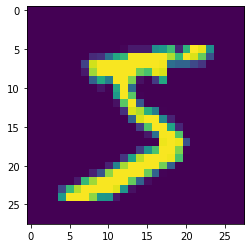

tensor(5)

In [ ]:
plt.imshow(train.data[0])
plt.show()
train.targets[0]

Обучение нейросети

In [ ]:
epochs = 100
loss_history = []
test_accuracy_history = []

X_test = test.data
y_test = test.targets

start = time.time()


for epoch_index in range(epochs):
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    x_batch = x_batch.reshape(x_batch.shape[0], -1).float()

    preds = mnist_net.forward(x_batch)
    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()

  test_preds = mnist_net.forward(X_test.reshape(X_test.shape[0], -1).float())

  test_loss = loss(test_preds, y_test)
  loss_history.append(loss_value.item())

  accuracy = accuracy_score(test_preds.argmax(dim=1), y_test)
  test_accuracy_history.append(accuracy)

print("Время обучения модели:", time.time()-start) 
print("Точность:", accuracy)
print("Лосс:", np.array(test_loss.data))

Время обучения модели: 836.3776016235352
Точность: 0.9232
Лосс: 0.31381395


Нарисуем два графика: потерь и точности

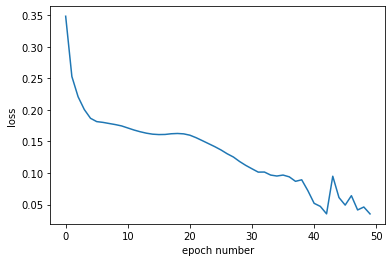

In [ ]:
plt.plot(loss_history)

plt.xlabel('epoch number')
plt.ylabel('loss')
plt.show()

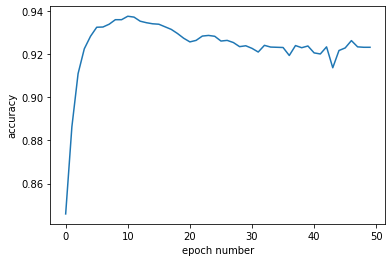

In [ ]:
plt.plot(test_accuracy_history)

plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.show()

Теперь создадим LeNet 2.0.

In [ ]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

Как и в полносвязной сети реализуем обучение и визуализацию.

In [ ]:
lenet = LeNet()


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3)


X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

batch_size = 100

test_accuracy_history = []
test_loss_history = []



start = time.time()

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data)
    
    accuracy = accuracy_score(test_preds.argmax(dim=1), y_test)
    test_accuracy_history.append(accuracy)


print("Время обучения модели:", time.time()-start) 
print("Точность:", accuracy)
print("Лосс:", np.array(test_loss.data))

Время обучения модели: 886.9841952323914
Точность: 0.9868
Лосс: 0.31381395


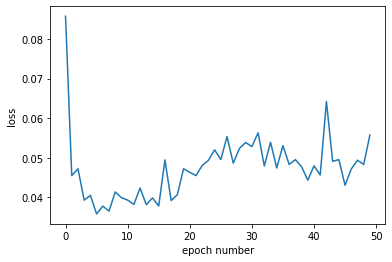

In [ ]:
plt.plot(test_loss_history)

plt.xlabel('epoch number')
plt.ylabel('loss')
plt.show()

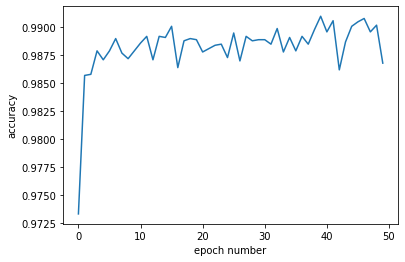

In [ ]:
plt.plot(test_accuracy_history);

plt.xlabel('epoch number')
plt.ylabel('accuracy')

plt.show()

<div>
    <h1><center>Заключение</center></h1>
</div>

1. Полносвязная нейронная сеть обучается на маленьких картинках быстрее.

2. Лосс значение в полносвязной нейронной сети в основном меньше, чем в сверточной, но после 100 эпох лосс практически одинаков. При этом в сверточной нейронной сети лосс значение сошлось быстрее, чем в полносвязнной нейронной сети.

3. Точность полносвязной нейронной сети в результате эксперимента оказалась меньше, что не удивительно.

4. 50 эпох для сети было много, так как лосс функция и точность быстро выходили на плато.
